In [1]:
from network import Network, Component, NetworkAnalyser
from io_utils import load_component, common_freqs_hz
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

## Network to be analysed

In [2]:
# Form Network
try:
    BASE = Path(__file__).parent
except NameError:
    BASE = Path.cwd()
PATH_TO_NETWORK_COMPONENTS = BASE / "data" / "configurations.json"
PATH_TO_S_PARAMETERS_FDR = BASE / "data" / "S_parameters"

with open(PATH_TO_NETWORK_COMPONENTS, "r") as f:
    cfg = json.load(f)

start_hz = int(cfg["global_frequency"]["start_hz"])
stop_hz = int(cfg["global_frequency"]["stop_hz"])

components_cfg = cfg["components"]

# Build components using only the matched frequency rows
components: list[Component] = []
for comp_data in components_cfg:
    components.append(
        load_component(comp_data, start_hz, stop_hz, PATH_TO_S_PARAMETERS_FDR)
    )

global_freqs = common_freqs_hz(components)
if not global_freqs:
    raise ValueError(
        "No common frequencies across all components within the given start and stop range."
    )

network = Network(components=components, freqs=global_freqs)

In [ ]:
# Creating a network with synthetic S21 Component (Linear phase response)
start_hz = 1e7
stop_hz  = 1e8

num_points = 5001    # frequency samples
freqs_hz = np.linspace(start_hz, stop_hz, num_points)

delay_s = 10e-6     # group delay
s21_db  = -20.0     # constant insertion loss
A = 10**(s21_db / 20)

s21 = A * np.exp(-1j * 2*np.pi * freqs_hz * delay_s)

S_parameter = {}

for f, val in zip(freqs_hz, s21):
    Smat = np.array(
        [[0.0 + 0.0j, 0.0 + 0.0j],
        [val,         0.0 + 0.0j]],
        dtype=np.complex128
    )
    S_parameter[np.int64(np.round(f))] = Smat

linear_s21_component = Component(
    name="synthetic_linear_s21",
    type="synthetic",
    S_parameter=S_parameter
)

network = Network(components=[linear_s21_component], freqs=freqs_hz)

In [45]:
phi = np.unwrap(np.angle(s21))
dphi_df = np.gradient(phi, freqs_hz)
tau_est = -(1/(2*np.pi)) * np.mean(dphi_df)

print("Recovered delay (us):", tau_est * 1e6)


Recovered delay (us): 9.999999999999996


## Define Chirp Signal

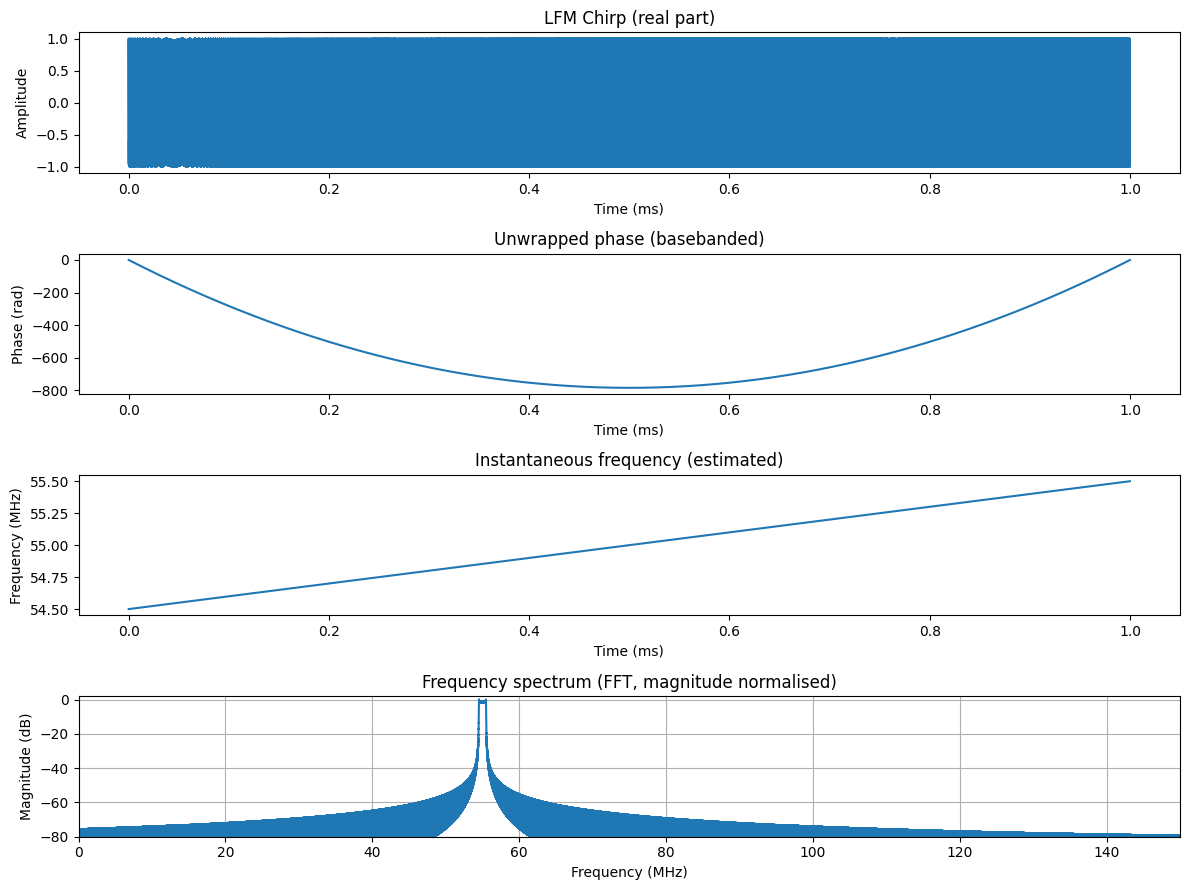

In [46]:
# LFM Parameters
BW = 1e6          # Bandwidth (Hz)
Tp = 1e-3         # Pulse duration (s)
gamma = BW / Tp   # Chirp rate (Hz/s)
f_c = (start_hz + stop_hz) / 2  # Centre frequency (Hz)

# Sampling
fs = stop_hz * 3        # Hz
N = int(np.round(Tp * fs))
t = np.arange(N) / fs

# Chirp centred in time
tc = t - Tp/2

# Instantaneous phase: 2π(f_c t + 0.5*gamma*t^2)
phi = 2*np.pi*(f_c * tc + 0.5 * gamma * tc**2)

# Complex LFM chirp
s = np.exp(1j * phi)

# Frequency spectrum (FFT)
zp = 8                       # zero padding factor
Nfft = zp * N
S = np.fft.fftshift(np.fft.fft(s, n=Nfft))
f = np.fft.fftshift(np.fft.fftfreq(Nfft, d=1/fs))

# Magnitude in dB (normalised)
S_mag = np.abs(S)
S_db = 20 * np.log10(S_mag / (np.max(S_mag) + 1e-12) + 1e-12)

# Plots
plt.figure(figsize=(12, 9))

plt.subplot(4, 1, 1)
plt.plot(t * 1e3, np.real(s))
plt.title("LFM Chirp (real part)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
plt.plot(t * 1e3, np.unwrap(np.angle(s)) - 2*np.pi*f_c*t) # Baseband
plt.title("Unwrapped phase (basebanded)")
plt.xlabel("Time (ms)")
plt.ylabel("Phase (rad)")

plt.subplot(4, 1, 3)
finst = np.diff(np.unwrap(np.angle(s))) * fs / (2*np.pi)
plt.plot(t[1:] * 1e3, finst / 1e6)
plt.title("Instantaneous frequency (estimated)")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency (MHz)")

plt.subplot(4, 1, 4)
plt.plot(f / 1e6, S_db)
plt.title("Frequency spectrum (FFT, magnitude normalised)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-80, 2)
plt.xlim(0, fs / 2 / 1e6)
plt.grid(True)

plt.tight_layout()
plt.show()


## Output of chirp signal after going through network
S-parameters are in frequency because they describe how a linear circuit responds to steady-state sinusoidal waves at each frequency.

For each frequency key `f`, insertion transfer is:

$H(f) = S_{21}(f)$

Then to apply S21 to the chirp $X(f)$, we do the frequency domain filtering:

$Y(f) = X(f) H(f)$

In [47]:
def extract_s21_from_dict(s_dict: dict) -> tuple[np.ndarray, np.ndarray]:
    freqs = np.array(sorted(s_dict.keys()), dtype=float)
    s21 = np.array([s_dict[f][1, 0] for f in freqs], dtype=np.complex128)
    return freqs, s21

def interp_complex_linear(x_new: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Interpolate real and imaginary parts separately for in between values
    yr = np.interp(x_new, x, np.real(y), left=0.0, right=0.0)
    yi = np.interp(x_new, x, np.imag(y), left=0.0, right=0.0)
    return yr + 1j * yi

def apply_freq_response(signal_t: np.ndarray, fs: float, f_meas: np.ndarray, h_meas: np.ndarray, zeropadding: int = 8):
    """
    Apply measured frequency response H(f) to a complex time signal.
    f_meas must be positive, increasing.
    Builds a two sided H on FFT bins via H(-f)=conj(H(f)).
    """
    N = len(signal_t)
    Nfft = int(zeropadding * N)

    X = np.fft.fft(signal_t, n=Nfft)
    f_bins = np.fft.fftfreq(Nfft, d=1/fs)

    H = np.zeros_like(f_bins, dtype=np.complex128)

    pos = f_bins >= 0
    f_pos = f_bins[pos]
    H[pos] = interp_complex_linear(f_pos, f_meas, h_meas)

    neg = ~pos
    f_neg = -f_bins[neg]
    H[neg] = np.conj(interp_complex_linear(f_neg, f_meas, h_meas))

    Y = X * H
    y = np.fft.ifft(Y)[:N]
    return y, f_bins, X, Y, H

def mag_db_abs(x: np.ndarray, floor_db: float = -200.0) -> np.ndarray:
    db = 20 * np.log10(np.abs(x) + 1e-15)
    return np.maximum(db, floor_db)

def mag_db_ratio(num: np.ndarray, den: np.ndarray, floor_db: float = -200.0) -> np.ndarray:
    db = 20 * np.log10((np.abs(num) + 1e-15) / (np.abs(den) + 1e-15))
    return np.maximum(db, floor_db)


# Get S-Parameter from network
S_Parameter = network.export_s_matrix()
f_s21, s21 = extract_s21_from_dict(S_Parameter)

# =========================
# Apply S21
# =========================
w = np.hanning(len(s))
# s_win = s * w  # In time domain
s_win = s  # In time domain

pad_us = 2000.0                      
pad = int(np.round(pad_us * 1e-6 * fs))   # number of samples to pad

s_pad = np.pad(s_win, (pad, pad))    # add zeros before and after
t_pad = (np.arange(len(s_pad)) - pad) / fs   # time axis centred so 0 is original start

y_pad, f_bins, X, Y, H = apply_freq_response(s_pad, fs, f_s21, s21, zeropadding=8)

# Shifted for plotting
f_shift = np.fft.fftshift(f_bins)
X_shift = np.fft.fftshift(X)
Y_shift = np.fft.fftshift(Y)
H_shift = np.fft.fftshift(H)

C:\Users\Keith Kwok\AppData\Local\Temp\ipykernel_7828\3175184165.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


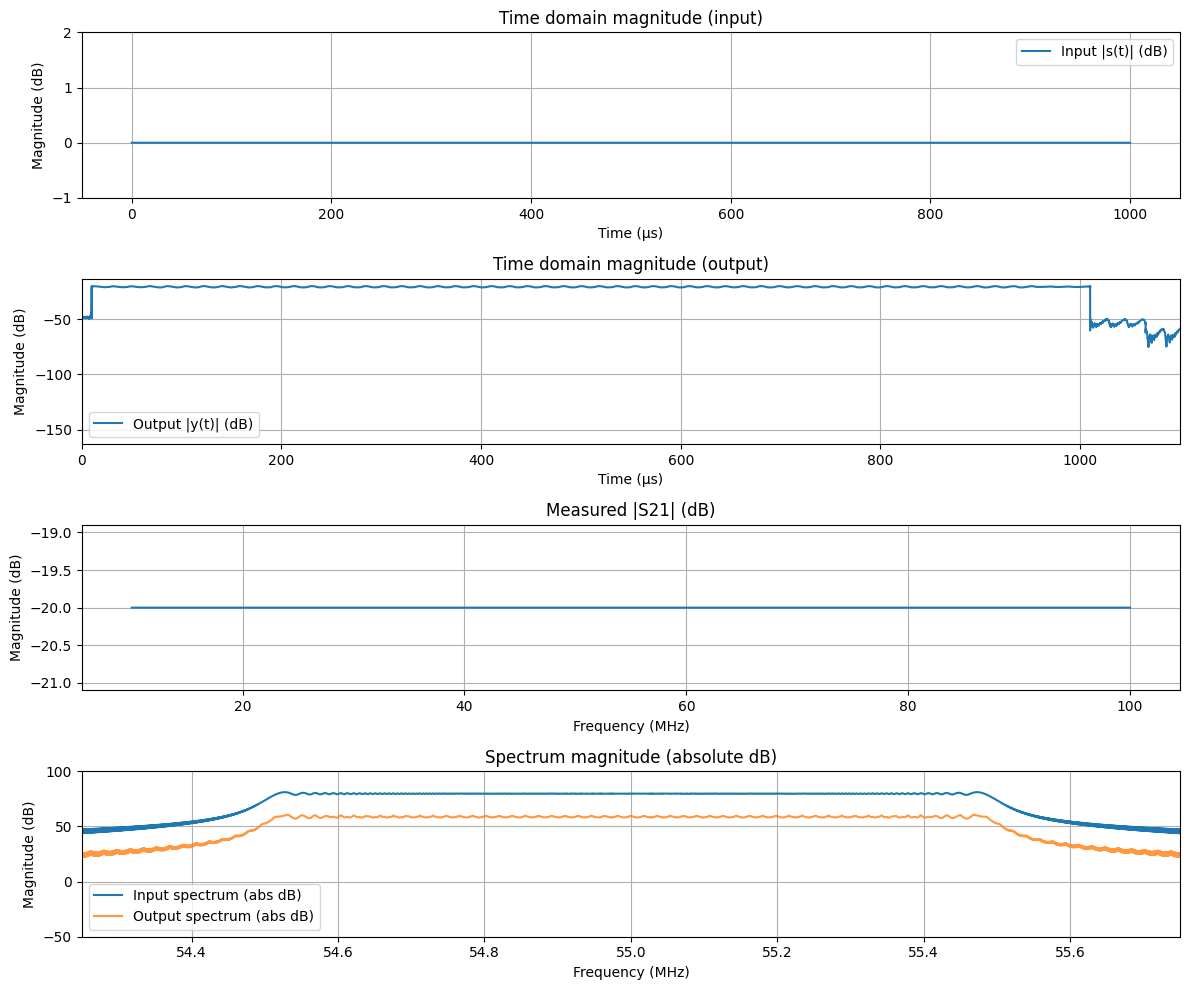

In [52]:
# =========================
# Plots
# =========================
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t * 1e6, 20*np.log10(np.abs(s) + 1e-15), label="Input |s(t)| (dB)")
plt.title("Time domain magnitude (input)")
plt.xlabel("Time (µs)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-1, 2)
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t_pad * 1e6, 20*np.log10(np.abs(y_pad) + 1e-15), label="Output |y(t)| (dB)")
plt.title("Time domain magnitude (output)")
plt.xlabel("Time (µs)")
plt.ylabel("Magnitude (dB)")
plt.xlim(0, 1100)
plt.grid(True)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(f_s21 / 1e6, 20 * np.log10(np.abs(s21) + 1e-15))
plt.title("Measured |S21| (dB)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(f_shift / 1e6, mag_db_abs(X_shift), label="Input spectrum (abs dB)")
plt.plot(f_shift / 1e6, mag_db_abs(Y_shift), label="Output spectrum (abs dB)", alpha=0.8)
plt.title("Spectrum magnitude (absolute dB)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(54.25, 55.75)
plt.ylim(-50, 100)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
phi_s21 = np.unwrap(np.angle(s21))
dphi_df = np.gradient(phi_s21, f_s21)
tau_est = -(1.0/(2*np.pi)) * np.mean(dphi_df)

print("Estimated delay from S21 slope (s):", tau_est)
print("Estimated delay from S21 slope (us):", tau_est * 1e6)

Estimated delay from S21 slope (s): 9.999999999999996e-06
Estimated delay from S21 slope (us): 9.999999999999996
